**Part D: A Real Text Classification Task**

---



Load all the datasets to DataFrames

In [0]:
import csv
dataset = []
import pandas as pd
with open('olid-training-v1.0.tsv') as tsvtrain:
  dataset = pd.read_csv(tsvtrain, delimiter='\t')

with open('testset-levela.tsv') as tsvtestA:
  testsetA = pd.read_csv(tsvtestA, delimiter='\t')

with open('labels-levela.csv') as tsvtestlabelA:
  labeltestsetA = pd.read_csv(tsvtestlabelA, names=["id", "subtask_a"])

with open('testset-levelb.tsv') as tsvtestB:
  testsetB = pd.read_csv(tsvtestB, delimiter='\t')

with open('labels-levelb.csv') as tsvtestlabelB:
  labeltestsetB = pd.read_csv(tsvtestlabelB, names=["id", "subtask_b"])

with open('testset-levelc.tsv') as tsvtestC:
  testsetC = pd.read_csv(tsvtestC, delimiter='\t')

with open('labels-levelc.csv') as tsvtestlabelC:
  labeltestsetC = pd.read_csv(tsvtestlabelC, names=["id", "subtask_c"])

Create Test Set for Subtask A: Here the three testsets are combined to create a single test_set with three columns

In [0]:
import numpy as np
test_set = testsetA.merge(labeltestsetA, how='outer', left_on="id", right_on="id")
test_set = test_set.merge(labeltestsetB, how='outer', left_on="id", right_on="id")
test_set = test_set.merge(labeltestsetC, how='outer', left_on="id", right_on="id")

In [3]:
test_set

,id,tweet,subtask_a,subtask_b,subtask_c
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,OFF,TIN,OTH
1,27014,"#ConstitutionDay is revered by Conservatives, ...",NOT,NaN,NaN
2,30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...,NOT,NaN,NaN
3,13876,#Watching #Boomer getting the news that she is...,NOT,NaN,NaN
4,60133,#NoPasaran: Unity demo to oppose the far-right...,OFF,TIN,GRP
...,...,...,...,...,...
855,73439,#DespicableDems lie again about rifles. Dem Di...,OFF,TIN,GRP
856,25657,#MeetTheSpeakers 🙌 @USER will present in our e...,NOT,NaN,NaN
857,67018,3 people just unfollowed me for talking about ...,OFF,UNT,NaN
858,50665,#WednesdayWisdom Antifa calls the right fascis...,NOT,NaN,NaN


Installing emoji 

In [4]:
!pip install emoji

**Preprocessing the data**

---



The twitter feed is preprocessed here. NLTK's tweet tokenizer is used which converts all string to lower case, strip the twitter handles (@USER) and reduces the length of repeated chars of more than length 3 to 3. A lemmatizer is also used to find and add the root word to the normalised corpus. Stopwords, numbers, punctuations and "url" are removed from the corpus.  Emoticons and hashtags are retained in the corpus as it gives a lot of meaning to the tweet and can be useful for text classification.

In [5]:
import nltk
from nltk.tokenize import TweetTokenizer 
from nltk.corpus import stopwords
import emoji
from nltk.stem import WordNetLemmatizer
import re

nltk.download('stopwords')
nltk.download('wordnet')
stopWords = set(stopwords.words('english'))
tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)
lemmatizer = WordNetLemmatizer() 

def pre_process(corpus):
  normalised_corpus = []
  for i, row in enumerate(corpus):
    wordsFiltered = []
    lines = tokenizer.tokenize(row)
    for words in lines:
      if words not in stopWords and words.isalpha()  and words != "url":
        words = lemmatizer.lemmatize(words)
        wordsFiltered.append(words)
      elif "#" in words or words in emoji.UNICODE_EMOJI:
        wordsFiltered.append(re.sub(r"#", "", words))
    final = " ".join(wordsFiltered)
    if len(final.strip().split())>0:  
      normalised_corpus.append(final.strip())
    else:
      normalised_corpus.append(None)
  return normalised_corpus




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Preprocessing the training dataset and removing tweets with None after preprocessing.

In [0]:
dataset["normal_tweet"] = pre_process(dataset["tweet"])
normalised_dataset = dataset.dropna(how='all', subset=['normal_tweet'])

Shape of the dataset before preprocessing

In [7]:
print("Shape of the dataset before preprocessing", dataset.shape)

Shape of the dataset before preprocessing (13240, 6)


Shape of the dataset after preprocessing:

In [8]:
print("Shape of the dataset after preprocessing", normalised_dataset.shape)

Shape of the dataset after preprocessing (13185, 6)


Example of unprocessed data

In [9]:
dataset["tweet"][10]

'@USER @USER @USER It’s not my fault you support gun control'

Example of processed data

In [10]:
dataset["normal_tweet"][10]

'fault support gun control'

Applying preprocessing to the testset as well

In [0]:
test_set["normal_tweet"] = pre_process(test_set["tweet"])
normalised_testset = test_set.dropna(how='all', subset=['normal_tweet'])

**Tokenizing the data**

---



here the training dataset is tokenized. Each word in the vocab is assigned a number and the sentences are constructed as a sequence of the numbers. A mapping from words to ids and ids to words is also generated.

In [12]:
train_data = normalised_dataset["normal_tweet"].tolist()

from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data)
word2idx = tokenizer.word_index
word2idx["<PAD>"] = 0

idx2word = {}
for key, value in word2idx.items():
  idx2word[value] = key

sents_as_ids = tokenizer.texts_to_sequences(train_data)
VOCAB_SIZE = len(word2idx) + 1 # 1 was added for zero padding

Using TensorFlow backend.


word to id mapping for an emoticon

In [13]:
word2idx["👊"]

1059

The vocab length ie the number of unique words in the vocabulary 

In [14]:
print("Number of unique words:", len(word2idx))

Number of unique words: 16955


A sentence represented as a seuqnces of ids

In [15]:
sents_as_ids[1]

[23, 180, 837, 6, 838, 1059, 25, 26, 1059]

Processing the training sequence to have them of the same length

In [16]:
from keras.preprocessing.sequence import pad_sequences
MAXIMUM_LENGTH = 200
print('Length of sample train_data before preprocessing:', len(sents_as_ids[0]))
preprocessed_train_data=pad_sequences(sents_as_ids, maxlen=MAXIMUM_LENGTH, padding='pre', truncating='pre')
print('Length of sample train_data after preprocessing:', len(preprocessed_train_data[0]))
print(preprocessed_train_data[0])


Length of sample train_data before preprocessing: 4
Length of sample train_data after preprocessing: 200
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0   

#Subtask A

Creating training labels. Mapping OFF to 1 and NOT to 0 as it is a binary classification task.

In [17]:
train_label = [1 if x == "OFF" else 0 for x in normalised_dataset["subtask_a"].tolist()]
print(train_label)

[1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 

Processing the test data: converting into IDs and padding it

In [18]:
test_data = tokenizer.texts_to_sequences(normalised_testset["normal_tweet"])
print('Length of sample test_data before preprocessing:', len(test_data[0]))
preprocessed_test_data=pad_sequences(test_data, maxlen=MAXIMUM_LENGTH, padding='pre', truncating='pre')
print('Length of sample test_data after preprocessing:', len(preprocessed_test_data[0]))
print(preprocessed_test_data[0])

Length of sample test_data before preprocessing: 19
Length of sample test_data after preprocessing: 200
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0  

Processing test labels

In [19]:
test_label = [1 if x == "OFF" else 0 for x in normalised_testset["subtask_a"].tolist()]
print(test_label)

[1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 

Using Glove Twitter Embedding (stored in drive) and creating a pretrained embedding layer. Only the embedding_matrix is created here which will be used as weights for the potential embedding layers. The twitter embedding can be found at https://nlp.stanford.edu/projects/glove/. Twitter embedding is used as the training dataset contains twitter feed. Moreover the embeddings are trainable so that it adapts to the changes in the training dataset. This helps in improving the overall accuracy of the task at hand.

In [20]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np

embeddings_index = {}
f = open('/content/drive/My Drive/glove.twitter.27B.200d.txt', 'r')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))
EMBEDDING_DIM = 200
embedding_matrix = np.zeros((len(word2idx) + 1, EMBEDDING_DIM))
for word, i in word2idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 1193514 word vectors.


Creating the model using Sequential API. The model has a pretrained embedding layer as the input layer. The second layer is an LSTM with 100 units and tanh activation followed by a dense output layer with sigmoid activation for the binary classification. The model uses Adam optimier the loss function "binary_crossentropy". An LSTM layer is used as LSTM are good at handling short and long term memory.

In [21]:
import keras
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.optimizers import Adam
model1 = Sequential()
model1.add(Embedding(len(word2idx) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAXIMUM_LENGTH,
                            trainable=True))
model1.add(LSTM(100, activation='tanh'))
model1.add(Dense(1, activation='sigmoid'))
optimizer = Adam()
model1.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])












Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [22]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 200)          3391200   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               120400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 3,511,701
Trainable params: 3,511,701
Non-trainable params: 0
_________________________________________________________________


Training the model for 3 epoch, batch size 100 with validation split at 0.1. The mentioned setting is used for all the models as it is seen that the models start to overfit almost always after the 3rd epoch. The validation split is at 0.1 as donating a large set of data for validation will hinder with the training and a small val set will not be representative of the test set accuracy. 

In [23]:
history1 = model1.fit(preprocessed_train_data, train_label, validation_split=0.1, epochs=3, batch_size=100)




Train on 11866 samples, validate on 1319 samples
Epoch 1/3
11866/11866 [==============================] - 79s 7ms/step - loss: 0.5223 - acc: 0.7446 - val_loss: 0.4562 - val_acc: 0.7945
Epoch 2/3
11866/11866 [==============================] - 80s 7ms/step - loss: 0.4063 - acc: 0.8181 - val_loss: 0.4570 - val_acc: 0.8006
Epoch 3/3
11866/11866 [==============================] - 79s 7ms/step - loss: 0.3236 - acc: 0.8611 - val_loss: 0.4994 - val_acc: 0.7801


Testing the model with the test set

In [24]:
result1 = model1.evaluate(preprocessed_test_data, test_label)
print('test_loss:', result1[0], 'test_accuracy:', result1[1])

859/859 [==============================] - 2s 2ms/step
test_loss: 0.47626729859462025 test_accuracy: 0.7904540162286325


The model gives an accuracy of about 80% when trained with trainable glove twitter embedding

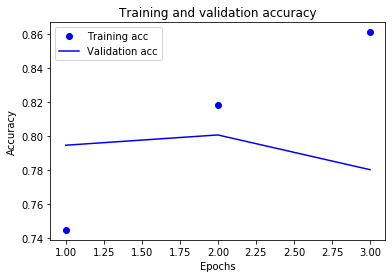

In [25]:
import matplotlib.pyplot as plt

history_dict = history1.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Given below is the confusion matrix

In [26]:
from sklearn.metrics import confusion_matrix
predicted_labels = model1.predict_classes(preprocessed_test_data)
confusion_matrix(test_label, predicted_labels)

array([[553,  66],
       [114, 126]])

#Subtask A-C combined

Preparing labels for subtask A-C combined

In [0]:
def provide_labels_AC (data):
    Y = []
    for index, row in data.iterrows():
      if (row['subtask_a']== "OFF"):
        if (row['subtask_b'] == "TIN"):
          if (row['subtask_c'] == "IND"):
            Y.append("OFF-TIN-IND")
          elif (row['subtask_c'] == "GRP"):
            Y.append("OFF-TIN-GRP")
          else:
            Y.append("OFF-TIN-OTH")
        else:
          Y.append("OFF-UNT")
      else:
        Y.append("NOT")
    return Y


Preparing training and testing labels

In [28]:
normalised_dataset["label"] = provide_labels_AC(normalised_dataset)
train_label_AC = pd.get_dummies(normalised_dataset['label']).values
print('Shape of training label tensor:', train_label_AC.shape)

normalised_testset["label"] = provide_labels_AC(normalised_testset)
test_label_AC = pd.get_dummies(normalised_testset['label']).values
print('Shape of testing label tensor:', test_label_AC.shape)

Shape of training label tensor: (13185, 5)
Shape of testing label tensor: (859, 5)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


For the task of classifying tweets under 5 categories, the model given below used the pretrained embedding layer (Glove twitter) with an SimpleRNN layer of 100 units with sigmoid activation function. tanh is used to introduce non linearity. This layer is followed by a dense output layer of 5 units as it is a multiclass classification output. The activation function used is Softmax for the last layer. The loss for the model is 'categorical_crossentropy' which is also consistent with the multiclass problem. An RNN model is used as it is good at capturing sequences. Few of the drawbacks is that is has a short term memory.

In [0]:
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Bidirectional, SimpleRNN
from keras.optimizers import Adam
model2 = Sequential()
model2.add(Embedding(len(word2idx) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAXIMUM_LENGTH,
                            trainable=True))
model2.add(Bidirectional(SimpleRNN(100, activation='tanh')))
model2.add(Dense(5, activation='softmax'))
optimizer = Adam()
model2.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [40]:
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 200)          3391200   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               60200     
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 1005      
Total params: 3,452,405
Trainable params: 3,452,405
Non-trainable params: 0
_________________________________________________________________


In [41]:
history2 = model2.fit(preprocessed_train_data, train_label_AC, validation_split=0.1, epochs=3, batch_size=100)

Train on 11866 samples, validate on 1319 samples
Epoch 1/3
11866/11866 [==============================] - 43s 4ms/step - loss: 0.9724 - acc: 0.6678 - val_loss: 0.8483 - val_acc: 0.6975
Epoch 2/3
11866/11866 [==============================] - 42s 4ms/step - loss: 0.8983 - acc: 0.6916 - val_loss: 0.8717 - val_acc: 0.6967
Epoch 3/3
11866/11866 [==============================] - 42s 4ms/step - loss: 0.7174 - acc: 0.7463 - val_loss: 0.8490 - val_acc: 0.7180


In [42]:
result2 = model2.evaluate(preprocessed_test_data, test_label_AC)
print('test_loss:', result2[0], 'test_accuracy:', result2[1])

859/859 [==============================] - 1s 1ms/step
test_loss: 0.784019811883378 test_accuracy: 0.7380675196092537


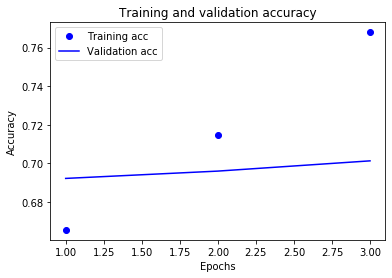

In [33]:
import matplotlib.pyplot as plt

history_dict = history2.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#Improving performance for A-C task

To improve the performance of the combined task, A CNN is used with the LSTM network. CNN are good at local structures and LSTMs are good at capturing global structure. Therefore the task at hand, categorising offensive tweets and the intended target requires both, the knowledge of short term and long term sequence. Thus a CNN and an LSTM architecture works best. However, a dropout layer is added to avoid overfitting as there are a lot of parameters to be trained on a limited set of data.

In [34]:
from keras.models import Model
from keras.layers import Dense, Dropout, Embedding, Bidirectional, SimpleRNN
from keras.layers.convolutional import Conv1D, MaxPooling1D

model3 = Sequential()
model3.add(Embedding(len(word2idx) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAXIMUM_LENGTH,
                            trainable=True))
model3.add(Conv1D(128, 5, activation='relu'))
model3.add(MaxPooling1D(pool_size=2))
model3.add(LSTM(100, activation='tanh'))
model3.add(Dense(15, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(5, activation='softmax'))
optimizer = Adam()
model3.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [35]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 200)          3391200   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 196, 128)          128128    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               91600     
_________________________________________________________________
dense_3 (Dense)              (None, 15)                1515      
_________________________________________________________________
dropout_1 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                

In [36]:
history3 = model3.fit(preprocessed_train_data, train_label_AC, validation_split=0.1, epochs=3, batch_size=100)

Train on 11866 samples, validate on 1319 samples
Epoch 1/3
11866/11866 [==============================] - 79s 7ms/step - loss: 1.1605 - acc: 0.6011 - val_loss: 0.9420 - val_acc: 0.6672
Epoch 2/3
11866/11866 [==============================] - 78s 7ms/step - loss: 0.9560 - acc: 0.6626 - val_loss: 0.8691 - val_acc: 0.6755
Epoch 3/3
11866/11866 [==============================] - 78s 7ms/step - loss: 0.8337 - acc: 0.6849 - val_loss: 0.8883 - val_acc: 0.7074


In [37]:
result3 = model3.evaluate(preprocessed_test_data, test_label_AC)
print('test_loss:', result3[0], 'test_accuracy:', result3[1])

859/859 [==============================] - 2s 2ms/step
test_loss: 0.8270215615543415 test_accuracy: 0.7427240977187373


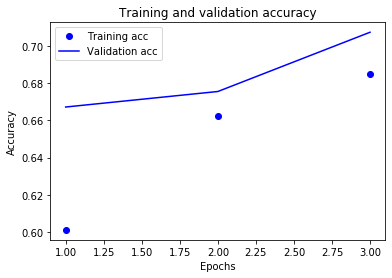

In [38]:
import matplotlib.pyplot as plt

history_dict = history3.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()